# 폐CT CNN 마스크 추출하기

**kaggle 폐 CT (Finding and Measuring Lungs in CT Data)** https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data

## img preprocess

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize

import os, glob

In [4]:
#이미지 불러오기
img_list = sorted(glob.glob('2d_images/*.tif'))
mask_list = sorted(glob.glob('2d_masks/*.tif'))

print(len(img_list), len(mask_list))

# .tif 형식의 이미지가 각 폴더당 267개씩 있음

267 267


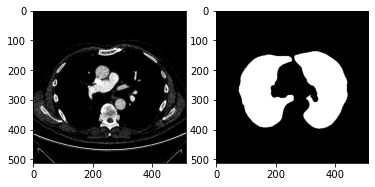

In [12]:
# 이미지 확인하기 ( CT와 마스크 이미지 )
import matplotlib.image as img

image1= img.imread('2d_images/ID_0000_Z_014.tif')
image2= img.imread('2d_masks/ID_0000_Z_0142.tif')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image1, cmap="gray")
ax[1].imshow(image2, cmap="gray")
plt.show()

In [13]:
IMG_SIZE = 256 #이미지 칼라사이즈는 256

x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

# image 
for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    x_data[i] = img
    
# mask
for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    y_data[i] = img
    
y_data /= 255.

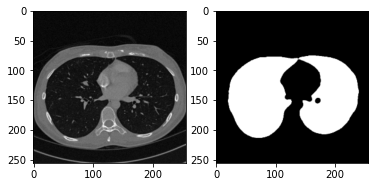

In [14]:
# 확인해보기
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].imshow(y_data[12].squeeze(), cmap='gray')

In [16]:
# 저장하기
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)

np.save('dataset/x_train.npy', x_train)
np.save('dataset/y_train.npy', y_train)
np.save('dataset/x_val.npy', x_val)
np.save('dataset/y_val.npy', y_val)

# 총 267개 중에서 분리하면
print(x_train.shape, y_train.shape) # train은 240개 (256*256*1)
print(x_val.shape, y_val.shape) # test는 27개 (256*256*1)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


## CNN train

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

### Load Dataset

전처리한 .npy 파일 불러오기

In [18]:
x_train = np.load('dataset/x_train.npy')
y_train = np.load('dataset/y_train.npy')
x_val = np.load('dataset/x_val.npy')
y_val = np.load('dataset/y_val.npy')

print(x_train.shape, y_train.shape) # train은 240개 (256*256*1)
print(x_val.shape, y_val.shape) # test는 27개 (256*256*1)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


### Build Model

* 텐서플로우 keras 활용 - Convolutional Enconder-Decoder
 - Encoder : 차원 축소를 통해 핵심요소만 뽑아내고
 - Decoder : 압축된 정보를 차원확장하여 원하는 정보로 복원하기

* Downsampling(MaxPooling2D) : 윈도우 크기 내 최대값 출력하는 Maxpooling
* Upsampling(UpSampling2D)

In [19]:
inputs = Input(shape=(256, 256, 1)) # 입력받고 

# kernel_size 연산수행 윈도우 크기 => 3
# padding 입출력 사이즈 => same (동일)
# pooling_size 압축 윈도우 크기 => 2  (1/2씩 압축)
net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)


#  이후 sigmoid 확률값으로 변환되기 전 Dense layer를 추가함  
net = Dense(128, activation='relu')(net)


# UpSampling 확장 윈도우 크기 => 2
# kernel_size 연산수행 윈도우 크기 => 3
# activation 활성화 함수 => sigmoid(흑백 이진분류니까)
net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)
#마지막 output 1채널로 변환시키기 


model = Model(inputs=inputs, outputs=outputs)
# 이진분류
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

### Train

In [20]:
# epoch => 100
# val_loss 모니터링 추가
# validation_split 검증데이터 비율 0.2
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=100, batch_size=32, 
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10,
                                                 verbose=1, mode='auto', min_lr=1e-05)])

Epoch 1/100
8/8 [==============================] - 39s 5s/step - loss: 0.5471 - acc: 0.7482 - mse: 0.1760 - val_loss: 0.4646 - val_acc: 0.7776 - val_mse: 0.1495 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 38s 5s/step - loss: 0.4606 - acc: 0.7481 - mse: 0.1510 - val_loss: 0.4226 - val_acc: 0.7770 - val_mse: 0.1374 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 38s 5s/step - loss: 0.4150 - acc: 0.7552 - mse: 0.1368 - val_loss: 0.3833 - val_acc: 0.7776 - val_mse: 0.1247 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 37s 5s/step - loss: 0.3946 - acc: 0.7609 - mse: 0.1302 - val_loss: 0.3606 - val_acc: 0.7817 - val_mse: 0.1176 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 38s 5s/step - loss: 0.3624 - acc: 0.7876 - mse: 0.1187 - val_loss: 0.3396 - val_acc: 0.7913 - val_mse: 0.1109 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 38s 5s/step - loss: 0.4059 - acc: 0.7698 - mse: 0.1346 - val_loss: 0.3979 - val

Epoch 48/100
8/8 [==============================] - 38s 5s/step - loss: 0.0615 - acc: 0.9566 - mse: 0.0128 - val_loss: 0.0618 - val_acc: 0.9571 - val_mse: 0.0145 - lr: 0.0010
Epoch 49/100
8/8 [==============================] - 37s 5s/step - loss: 0.0644 - acc: 0.9559 - mse: 0.0135 - val_loss: 0.0464 - val_acc: 0.9624 - val_mse: 0.0100 - lr: 0.0010
Epoch 50/100
8/8 [==============================] - 38s 5s/step - loss: 0.0715 - acc: 0.9524 - mse: 0.0160 - val_loss: 0.0503 - val_acc: 0.9615 - val_mse: 0.0109 - lr: 0.0010
Epoch 51/100
8/8 [==============================] - 37s 5s/step - loss: 0.0690 - acc: 0.9548 - mse: 0.0150 - val_loss: 0.0506 - val_acc: 0.9622 - val_mse: 0.0115 - lr: 0.0010
Epoch 52/100
8/8 [==============================] - 37s 5s/step - loss: 0.0629 - acc: 0.9564 - mse: 0.0131 - val_loss: 0.0479 - val_acc: 0.9618 - val_mse: 0.0104 - lr: 0.0010
Epoch 53/100
8/8 [==============================] - 38s 5s/step - loss: 0.0622 - acc: 0.9560 - mse: 0.0132 - val_loss: 0.0694

Epoch 95/100
8/8 [==============================] - 1225s 5s/step - loss: 0.0466 - acc: 0.9595 - mse: 0.0093 - val_loss: 0.0347 - val_acc: 0.9655 - val_mse: 0.0066 - lr: 0.0010
Epoch 96/100
8/8 [==============================] - 38s 5s/step - loss: 0.0440 - acc: 0.9605 - mse: 0.0085 - val_loss: 0.0326 - val_acc: 0.9660 - val_mse: 0.0063 - lr: 0.0010
Epoch 97/100
8/8 [==============================] - 42s 5s/step - loss: 0.0445 - acc: 0.9605 - mse: 0.0085 - val_loss: 0.0332 - val_acc: 0.9658 - val_mse: 0.0063 - lr: 0.0010
Epoch 98/100
8/8 [==============================] - 40s 5s/step - loss: 0.0437 - acc: 0.9607 - mse: 0.0083 - val_loss: 0.0443 - val_acc: 0.9628 - val_mse: 0.0094 - lr: 0.0010
Epoch 99/100
8/8 [==============================] - 39s 5s/step - loss: 0.0448 - acc: 0.9602 - mse: 0.0089 - val_loss: 0.0378 - val_acc: 0.9653 - val_mse: 0.0075 - lr: 0.0010
Epoch 100/100
8/8 [==============================] - 39s 5s/step - loss: 0.0432 - acc: 0.9607 - mse: 0.0083 - val_loss: 0.0

### Evaluation

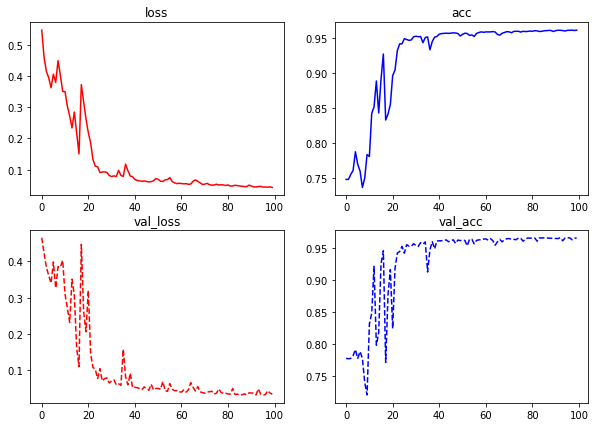

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

### Prediction

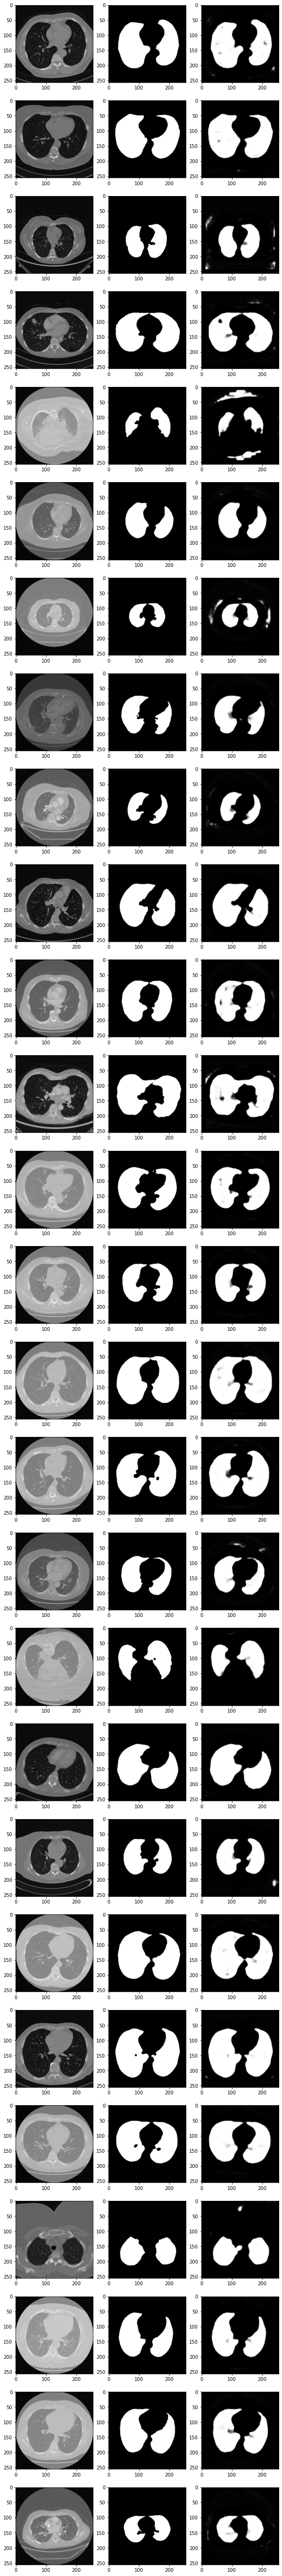

In [22]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')